In [1]:
import sys
import re
sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')

import glob
import numpy as np

from numpy import fft

import matplotlib.pyplot as plt

from frxas import time_domain, models, hdf5_io
from lmfit import fit_report
%reload_ext autoreload
%autoreload 2

In [4]:
direc = r'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\July2018 Data Fits\\1% O2'
f_target = r'\\0.25 Hz 150 mV '
print(direc + f_target)
all_files = glob.glob(direc + f_target + r'P*_Ir.h5')
all_files
dum = hdf5_io.load_time_domain_fit(all_files[0][:-3])

C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\July2018 Data Fits\\1% O2\\0.25 Hz 150 mV 


In [5]:
direc = r'D:\\UW Research\\fr-XAS July 2018\\Data\\1% O2\\0.25 Hz 150 mV'
amp = ''
harmonics = 4
fit_kws={'ftol':1e-13, 'xtol':1e-13}


for i in range(10, 11):
    point = f'\\P{i}'
    all_files = glob.glob(direc + point+ '\\R[0-9] [0-9]*.txt')
    last_run = 0
    for files in all_files:
        run_ind = int(files.split('\\')[-1][1])
        if  run_ind > last_run:
            last_run = run_ind 

    file = r'\R' + str(last_run)
    print(direc+point+amp+file)

    ti, V, J, Ir = time_domain.extract_data(direc, point, amp, file, end=301)

    Ns = ti.size
    freq_in = time_domain.get_freq(direc, point, amp, file)
    if Ns%2 == 1:
        Ns = Ns - 1
        ti = ti[:-1]
        V = V[:-1]
        J = J[:-1]
        Ir = Ir[:-1]
    b = 0.1 * freq_in * (ti[-1]+ti[1])
    freq_bin_1 = time_domain.freq_bin(freq_in, fft.fftshift(fft.fftfreq(Ns, ti[1])), harmonic=1)
    frequencies = fft.fftshift(fft.fftfreq(Ns, ti[1]))
    weights = np.ones((Ns,))
    for i in range(0, 10):
        weights[freq_bin_1+i] = 1
        weights[freq_bin_1-i] = 1
    
#     J_adj, J_adj_fit = time_domain.phase_align(ti, V, J, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws)
    Ir_adj, Ir_adj_fit = time_domain.phase_align(ti, Ir, Ir, freq_in, b, phase=-126.63795193873473, harmonics=harmonics, weights=weights)
#     V_adj, V_adj_fit = time_domain.phase_align(ti, V, V, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws, weights=weights)

#     hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_J', J_adj_fit)
#     hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_Ir', Ir_adj_fit)
#     hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_V', V_adj_fit)

D:\\UW Research\\fr-XAS July 2018\\Data\\1% O2\\0.25 Hz 150 mV\P10\R1


In [7]:
Ir_adj_fit.params['h1_re_comp'].stderr = None

In [3]:
Ir_adj_fit.params['h1_re_comp'].stderr

4.274265342128452e-06

In [63]:
%timeit hdf5_io.save_time_domain_fit('testshit3', Ir_adj_fit, save_data=True)

11 ms ± 705 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%timeit hdf5_io.save_time_domain_fit('testshit4', Ir_adj_fit)

14.2 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
dum = hdf5_io.load_time_domain_fit('testshit4')

In [72]:
print(fit_report(dum))
print(fit_report(Ir_adj_fit))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 394800
    # variables        = 8
    chi-square         = 2.2704e-08
    reduced chi-square = 5.7508e-14
    Akaike info crit   = -12036204.2
    Bayesian info crit = -12036117.1
[[Variables]]
    h1_harmonic:  1 (fixed)
    h1_re_comp:  -0.00284305 +/- 4.2743e-06 (0.15%) (init = 0)
    h1_im_comp:  -0.00382287 +/- 4.2610e-06 (0.11%) (init = -1)
    h2_harmonic:  2 (fixed)
    h2_re_comp:  -8.2020e-04 +/- 4.2713e-06 (0.52%) (init = 0)
    h2_im_comp:   0.00101133 +/- 4.2725e-06 (0.42%) (init = -1)
    h3_harmonic:  3 (fixed)
    h3_re_comp:   2.9210e-04 +/- 4.2690e-06 (1.46%) (init = 0)
    h3_im_comp:   1.8853e-04 +/- 4.2736e-06 (2.27%) (init = -1)
    h4_harmonic:  4 (fixed)
    h4_re_comp:  -5.8235e-06 +/- 4.2617e-06 (73.18%) (init = 0)
    h4_im_comp:   5.8274e-05 +/- 4.2690e-06 (7.33%) (init = -1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19


In [12]:
dum.fit()
dum

In [340]:
fit_kws={'ftol':1e-13, 'xtol':1e-13}
aa = time_domain.fit_windowed_fft(frequencies, time_domain.get_windowed_fft(ti, Ir, freq_in, b), freq_in, b, fit_kws=fit_kws)
print(np.angle(aa.params['h1_re_comp'].value + 1j *aa.params['h1_im_comp'].value,deg=True))

-126.63795193873473


In [341]:
print(np.angle(aa.params['h1_re_comp'].value + 1j *aa.params['h1_im_comp'].value,deg=True))
print(np.angle(Ir_adj_fit.params['h1_re_comp'].value + 1j * Ir_adj_fit.params['h1_im_comp'].value,deg=True))

-126.63795193873473
-126.63795193521119


In [330]:
res_act = np.sum((Ir_adj_fit.eval() - dum2).ravel().view(np.float)**2)
res_mod = np.sum((Ir_adj_fit.eval() - dum).ravel().view(np.float)**2)
print(f'Actual: {res_act:.5e}  Model: {res_mod:.5e}')

Actual: 2.86761e-08  Model: 5.50330e-09


In [403]:
model_result.params['h1_re_comp'].stderr

4.274265342128452e-06

In [1]:
model_result.params

NameError: name 'model_result' is not defined

In [362]:
print(np.sum((model_result.data - dum).ravel().view(np.float)**2))
print(np.sum((model_result.eval() - dum).ravel().view(np.float)**2))
print(np.sum((model_result.data - model_result.eval()).ravel().view(np.float)**2))
print(np.sum((model_result.data - dum2).ravel().view(np.float)**2))
print(np.sum((dum3 - dum2).ravel().view(np.float)**2))

2.8443436206007186e-08
2.2703646078309998e-08
5.768745716368871e-09
3.788821145063409e-39
0.0


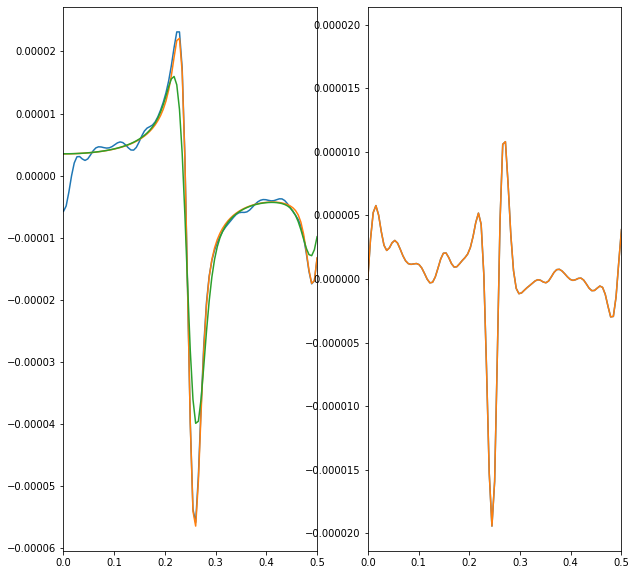

In [389]:
xlims= (0,.5)
model_result = Ir_adj_fit
dt = 1/ (model_result.userkws['frequencies'][0]*-2)
freq_in = model_result.userkws['freq_in']
b = model_result.userkws['window_param']
ti = np.arange(0, model_result.ndata/2) * dt
dum = time_domain.get_windowed_fft(ti, Ir, freq_in, b)
dum2 = time_domain.get_windowed_fft(ti, Ir_adj, freq_in, b)

dum3 = time_domain.get_windowed_fft(ti, fft.ifft(fft.ifftshift(model_result.eval())*(Ns*np.pi)), freq_in, b)
# dum2 and dum3 completely equivalent and very close to to model_result.data
# model_result.eval() very close to real data, but model_result.data still off a little

_, ax1=plt.subplots(ncols=2, figsize=(10,10))
# ax1[0].plot(freqs, dum.real-model_result.eval().real, label=point)
# ax1[0].plot(freqs, dum.real-model_result.data.real)
# ax1[0].plot(freqs, dum.real-dum2.real)
ax1[0].plot(freqs, dum.real)
ax1[0].plot(freqs, model_result.eval().real, label=point)
ax1[0].plot(freqs, model_result.data.real)

ax1[0].set_xlim(xlims)

# ax1[1].plot(freqs, dum2.imag-model_result.eval().imag, label=point)
ax1[1].plot(freqs, dum.imag-dum2.imag)
ax1[1].plot(freqs, dum.imag-dum3.imag)
ax1[1].set_xlim(xlims)

plt.show()

In [ ]:
model_result.

c:\users\shadd\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


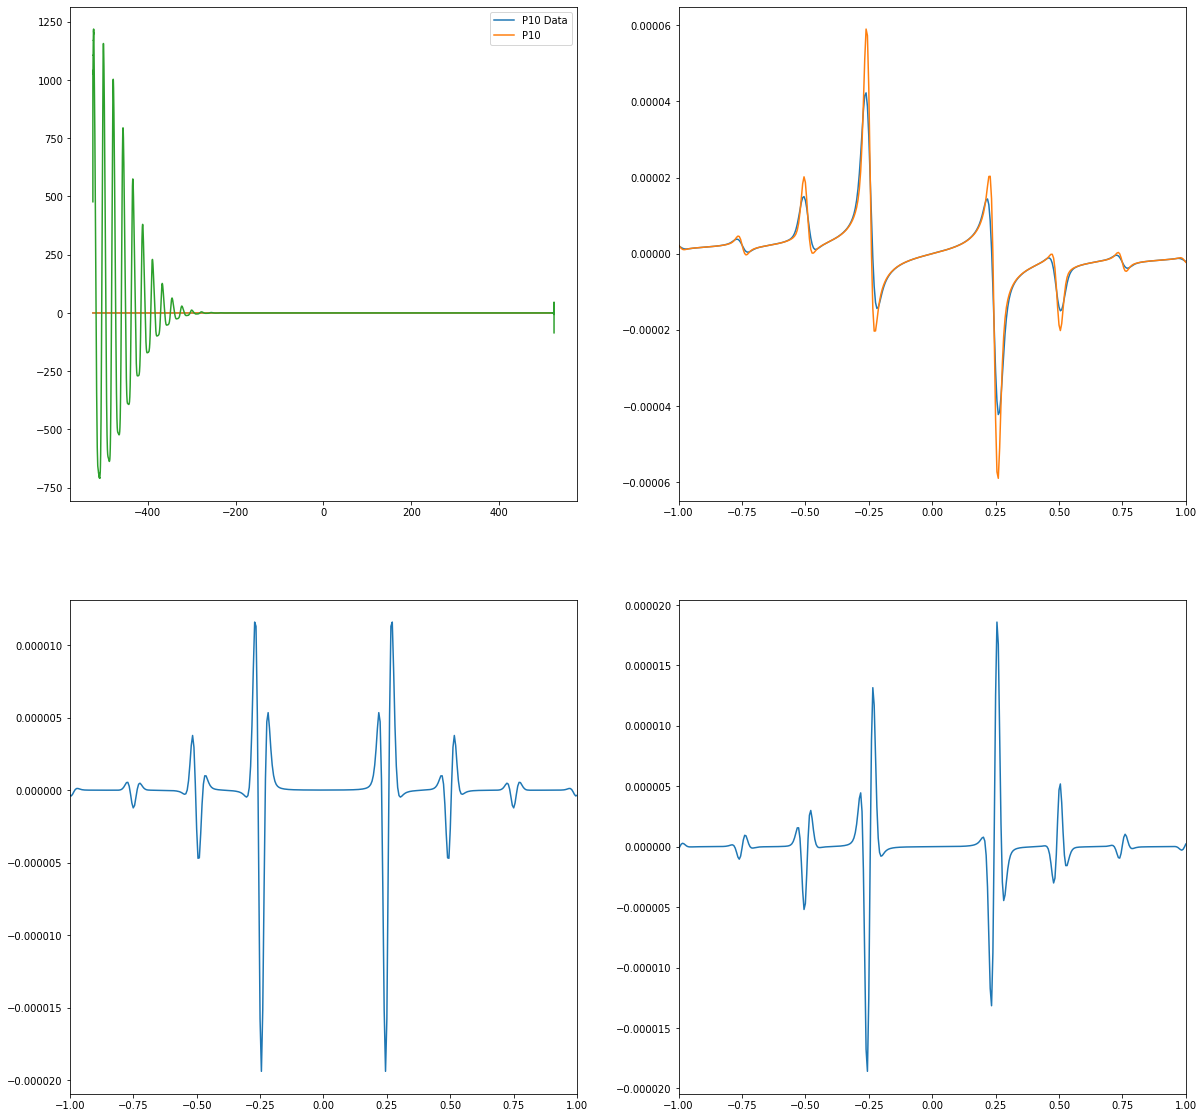

In [259]:
_, (ax1, ax2)  = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
xlims = (-1, 1)
re_1 = []
im_1 = []
for file in all_files[:1]:
    
    point = file.split('mV ')[-1].split('_')[0]
    model_result = hdf5_io.load_time_domain_fit(file.split('.h5')[0])
    freqs = model_result.userkws['frequencies']
    re_1.append(model_result.params['h1_re_comp'].value)
    im_1.append(model_result.params['h1_re_comp'].value)

    ax1[0].plot(freqs, model_result.eval().real, label=point)
#     ax1[0].set_xlim(xlims)

    ax1[1].plot(freqs, model_result.eval().imag, label=point)
    ax1[1].set_xlim(xlims)
    
    ax2[0].plot(freqs, model_result.data.real - model_result.eval().real, label=point)
    ax2[0].set_xlim(xlims)

    ax2[1].plot(freqs, model_result.data.imag - model_result.eval().imag, label=point)
    ax2[1].set_xlim(xlims)

ax1[0].legend()
plt.show()

In [214]:
direc = r'D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV'


for i in range(1, 22):
    point = f'\\P{i}'
    all_files = glob.glob(direc + point+ '\\R[0-9] [0-9]*.txt')
    last_run = 0
    for files in all_files:
        run_ind = int(files.split('\\')[-1][1])
        if  run_ind > last_run:
            last_run = run_ind 
    amp = ''
    file = r'\R' + str(last_run)
    print(direc+point+amp+file)

    ti, V, J, Ir = time_domain.extract_data(direc, point, amp, file, end=301)

D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P1\R2
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P2\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P3\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P4\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P5\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P6\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P7\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P8\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P9\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P10\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P11\R2
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P12\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P13\R2


KeyboardInterrupt: 

In [218]:
%%time
direc = r'D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV'
freq = r'\0.25 Hz 150mV'
point = r'\P2'

# Find last run collected in case there were false starts
all_files = glob.glob(direc + point+ '\\R[0-9] [0-9]*.txt')
last_run = 0
for files in all_files:
    run_ind = int(files.split('\\')[-1][1])
    if  run_ind > last_run:
        last_run = run_ind 
amp = ''
file = r'\R' + str(last_run)
print(direc+point+amp+file)

ti, V, J, Ir = time_domain.extract_data(direc, point, amp, file, end=301)

match = re.search(r'\d+% O2', direc)
if match:
    gas = match.group()

Ns = ti.size
freq_in = time_domain.get_freq(direc, point, amp, file)
if Ns%2 == 1:
    Ns = Ns - 1
    ti = ti[:-1]
    V = V[:-1]
    J = J[:-1]
    Ir = Ir[:-1]

freq_bin_1 = time_domain.freq_bin(freq_in, fft.fftshift(fft.fftfreq(Ns, ti[1])), harmonic=1)
frequencies = fft.fftshift(fft.fftfreq(Ns, ti[1]))
weights = np.ones((Ns,))
for i in range(0, 10):
    weights[freq_bin_1+i] = 1
    weights[freq_bin_1-i] = 1

D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P2\R0


IndexError: list index out of range

In [217]:
%%time
b = 0.1 * f * (ti[-1]+ti[1])
harmonics = 1
fit_kws={'ftol':1e-13, 'xtol':1e-13}
J_adj, J_adj_fit = time_domain.phase_align(ti, V, J, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws)
Ir_adj, Ir_adj_fit = time_domain.phase_align(ti, V, Ir, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws, weights=weights)
V_adj, V_adj_fit = time_domain.phase_align(ti, V, V, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws, weights=weights)

# hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_J', J_adj_fit)
# hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_Ir', Ir_adj_fit)
# hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_V', V_adj_fit)

ValueError: operands could not be broadcast together with shapes (646800,) (394800,) (646800,) 

In [194]:
Ir_adj_fit

ValueError: x and y must have same first dimension, but have shapes (323400,) and (197400,)

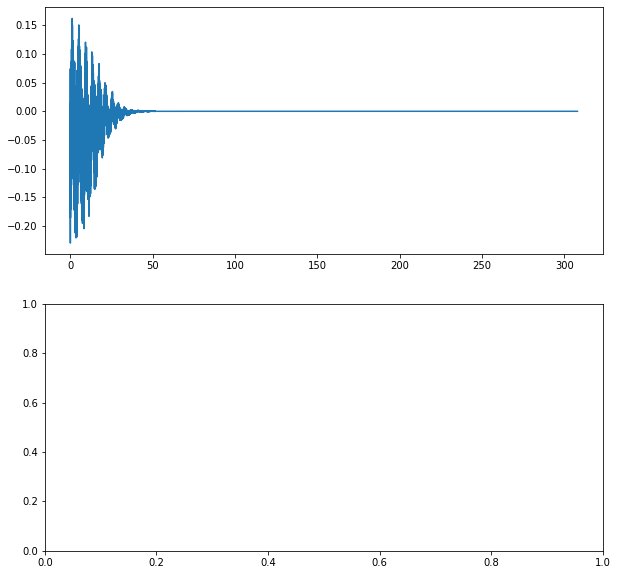

In [216]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
ax1.plot(ti, time_domain.gauss_window(Ir, freq_in, ti, b)*20)
ax1.plot(ti, Ir_adj*20)
# ax1.plot(ti, time_domain.gauss_window(V, freq_in, ti, b))
# ax1.plot(ti, V_adj)
ax1.set_xlim(0, 60)

ax2.plot(frequencies, Ir_adj_fit.eval().real)
ax2.plot(frequencies, time_domain.get_windowed_fft(ti, Ir, freq_in, b).real)
# ax2.plot(freq_list, V_adj_fit.eval().real)
# ax2.plot(freq_list, V_adj_fit.data.real)
ax2.set_xlim(-1, 1)

plt.show()

c:\users\shadd\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\shadd\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


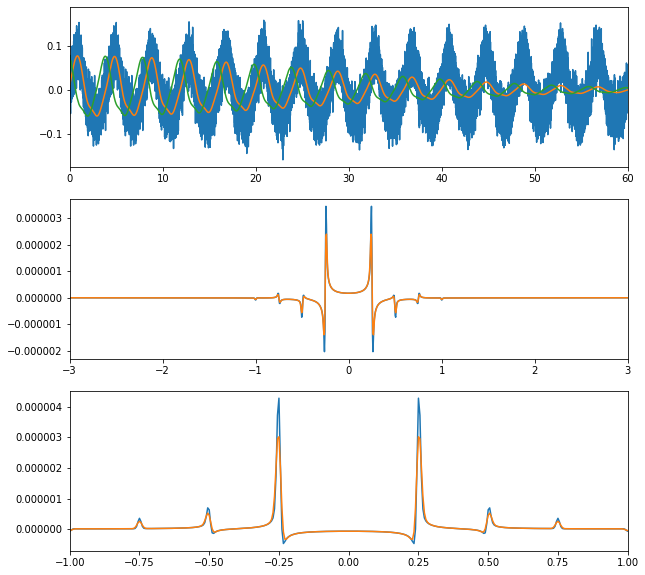

In [141]:
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10,10))
ax1.plot(ti, J*400)
ax1.plot(ti, J_adj*400)
ax1.plot(ti, J_adj2*400)
ax1.set_xlim(0, 60)

freq_list = J_adj_fit2.userkws['frequencies']
ax2.plot(freq_list, J_adj_fit.eval().real)
ax2.plot(freq_list, J_adj_fit.data.real)
ax2.set_xlim(-3, 3)

ax3.plot(freq_list, J_adj_fit2.eval().real)
ax3.plot(freq_list, J_adj_fit2.data.real)
ax3.set_xlim(-1, 1)
# ax2.set_ylim(-1e-6,1e-6)
plt.show()

In [44]:
J_adj_fit.data - J_adj_fit2.data

array([2.97858081e-09+2.11052041e-09j, 6.84697198e-09+4.05240713e-09j,
       1.08302991e-08+2.09201658e-09j, ...,
       1.08302991e-08-2.09201658e-09j, 6.84697198e-09-4.05240713e-09j,
       2.97858081e-09-2.11052041e-09j])

In [46]:
time_domain.get_windowed_fft()

In [76]:
aa = 'str'
bb= 15
cc =1.5

isinstance(bb, str)

False